In [1]:
# open the generated synthetic data file and read it as a python dictionary called data

import json

file = open('synthetic_dataset_with_time.txt', 'r')
text = file.read()
data = json.loads(text)


In [2]:
import emip_toolkit as EMTK

# find areas of interest (AOIs) once again
image_path = "./"
image = "synthetic_text.png"
aoi = EMTK.find_aoi(image, image_path, level="sub-line")


# add tokens to AOIs 
file_path = "./"
aois_with_tokens = EMTK.add_tokens_to_AOIs(file_path, image.split(".")[0]+".txt", aoi)
aois_with_tokens.head()


import correction

# find the y coordinate of each line in the text
line_ys = correction.find_lines_Y(aoi)

/Users/feng_0/Desktop/cs421/CS421-project1/emip_toolkit.py:1255: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  aoi = aoi.append(dic, ignore_index=True)
/Users/feng_0/Desktop/cs421/CS421-project1/emip_toolkit.py:1255: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  aoi = aoi.append(dic, ignore_index=True)
/Users/feng_0/Desktop/cs421/CS421-project1/emip_toolkit.py:1255: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  aoi = aoi.append(dic, ignore_index=True)
/Users/feng_0/Desktop/cs421/CS421-project1/emip_toolkit.py:1255: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  aoi = aoi.append(dic, ignore_index=True)
/Users/feng_0/Desktop/cs421/CS421-pr

In [3]:
import numpy as np
import drift_algorithms as algo
from tqdm import tqdm

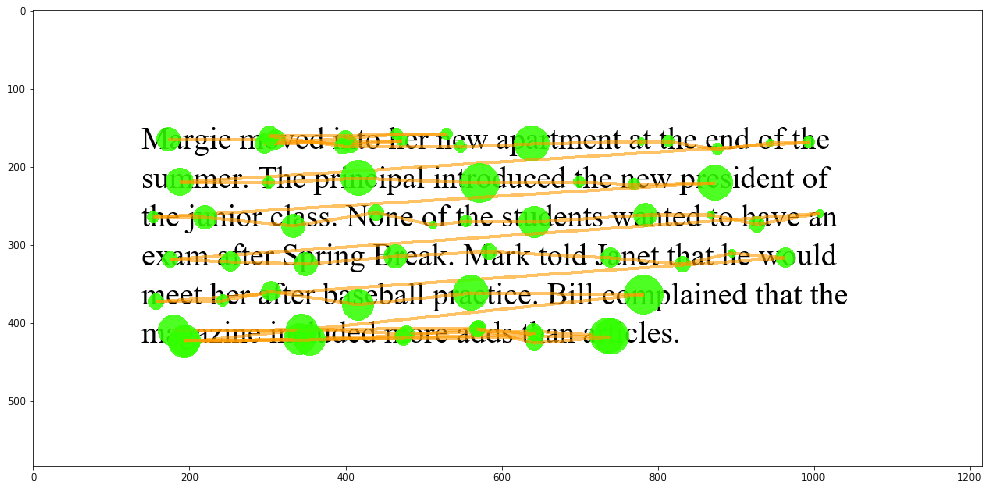

In [4]:
# draw original correct fixations

correction.draw_fixation('synthetic_text.png', data['robot1'].copy())

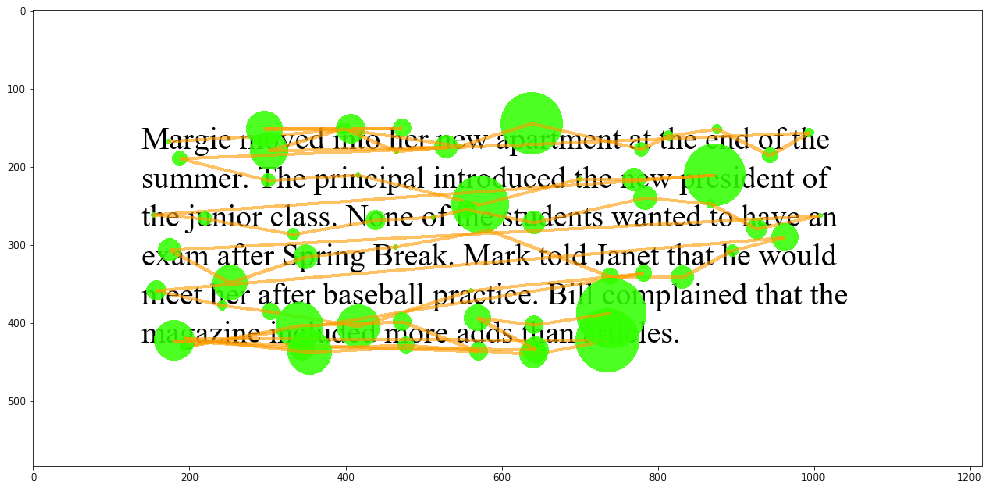

In [5]:
# generate noise over the correct trial

error_test = correction.error_noise(1, 30, 1, data['robot1'].copy())

# draw the trial with added error
correction.draw_fixation('synthetic_text.png', error_test)

1.0


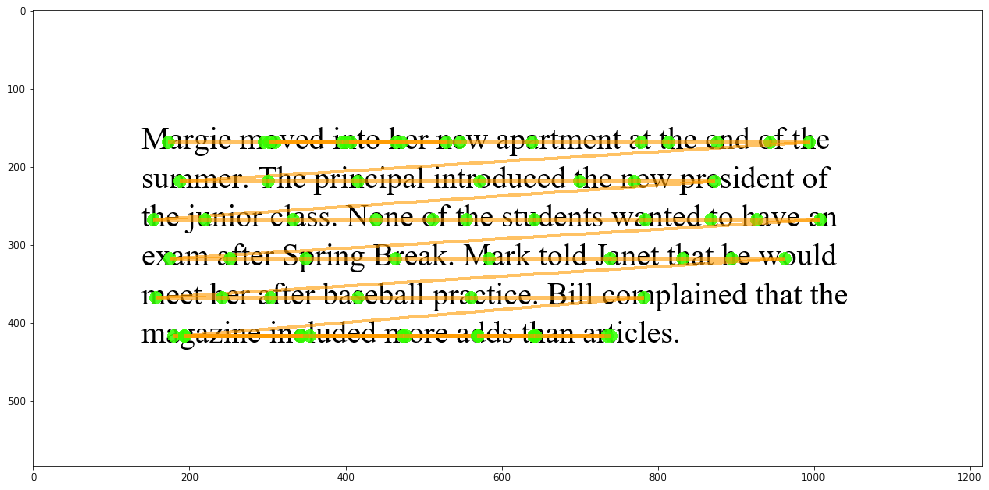

In [6]:
# find the center of each word, we need this for warp algorithm
word_centers = correction.find_word_centers(aoi)
word_centers = np.array(word_centers.copy(), dtype=int)

# warp correction
np_array = np.array(error_test.copy(), dtype=int)
durations = np.delete(np_array, 0, 1)
durations = np.delete(durations, 0, 1)
np_array = np.delete(np_array, 2, 1)

# run warp
warp_correction = algo.warp(np_array, word_centers)

# this is a cool function that checks the quality of the correction
percentage, match_list = correction.correction_quality(aoi, data['robot1'].copy(), warp_correction)
print(percentage)

# this is a cool function that draws the correction in red if the algorithm made a mistake
correction.draw_correction('synthetic_text.png', warp_correction, match_list)

This concludes the example I wanted to show you of running an error generator, then correcting the data, then seeing how well the correction algorithm did.  You will need to repeat the same concept for a bunch of algorithms in the next section.

# Comparing algorithms with Noise error:

In this example, I show you one type of erro "Noise" you will implement all 5 types and add skipping to your assessment.  Also, the code below runs only 4 algorithms, you will add the remaining 6 algorithms to this assessment for each type of error. 

In [7]:
attach_results = [[],[],[],[],[],[],[],[],[],[],[]]
chain_results = [[],[],[],[],[],[],[],[],[],[],[]]
cluster_results = [[],[],[],[],[],[],[],[],[],[],[]]
compare_results = [[],[],[],[],[],[],[],[],[],[],[]]
merge_results = [[],[],[],[],[],[],[],[],[],[],[]]
regress_results = [[],[],[],[],[],[],[],[],[],[],[]]
segment_results = [[],[],[],[],[],[],[],[],[],[],[]]
split_results = [[],[],[],[],[],[],[],[],[],[],[]]
stretch_results = [[],[],[],[],[],[],[],[],[],[],[]]
warp_results = [[],[],[],[],[],[],[],[],[],[],[]]

word_centers = correction.find_word_centers(aoi)
word_centers = np.array(word_centers.copy(), dtype=int)

duration_word_centers = correction.find_word_centers_and_duration(aois_with_tokens)
duration_word_centers = np.array(duration_word_centers.copy(), dtype=int)

# MAKE SURE YOU RUN THIS 100 TIMES, NOT JUST ONE!!!
for robot_index in tqdm(range(100)):
    
    for error_probability in range(0, 11):
        # generate error
        error_test = correction.error_noise(error_probability/10, 30, error_probability/10, data['robot' + str(robot_index)].copy())

        # attach correction
        np_array = np.array(error_test.copy())
        attach_correction = algo.attach(np_array, line_ys)
        percentage, match_list = correction.correction_quality(aoi, data['robot' + str(robot_index)].copy(), attach_correction)
        attach_results[error_probability].append(percentage)

        # chain correction
        np_array = np.array(error_test.copy())
        chain_correction = algo.chain(np_array, line_ys)
        percentage, match_list = correction.correction_quality(aoi, data['robot' + str(robot_index)].copy(), chain_correction)
        chain_results[error_probability].append(percentage)
        
        # cluster correction
        np_array = np.array(error_test.copy())
        cluster_correction = algo.cluster(np_array, line_ys)
        percentage, match_list = correction.correction_quality(aoi, data['robot' + str(robot_index)].copy(), cluster_correction)
        cluster_results[error_probability].append(percentage)
        
        # compare correction
        np_array = np.array(error_test.copy(), dtype=int)
        durations = np.delete(np_array, 0, 1)
        durations = np.delete(durations, 0, 1)
        np_array = np.delete(np_array, 2, 1)
        
        compare_correction = algo.compare(np_array, word_centers)
        percentage, match_list = correction.correction_quality(aoi, data['robot' + str(robot_index)].copy(), compare_correction)
        compare_results[error_probability].append(percentage)
        
        # merge correction
        np_array = np.array(error_test.copy())
        merge_correction = algo.merge(np_array, line_ys)
        percentage, match_list = correction.correction_quality(aoi, data['robot' + str(robot_index)].copy(), merge_correction)
        merge_results[error_probability].append(percentage)
        
        # regress correction
        np_array = np.array(error_test.copy())
        regress_correction = algo.regress(np_array, line_ys)
        percentage, match_list = correction.correction_quality(aoi, data['robot' + str(robot_index)].copy(), regress_correction)
        regress_results[error_probability].append(percentage)
        
        # segment correction
        np_array = np.array(error_test.copy())
        segment_correction = algo.segment(np_array, line_ys)
        percentage, match_list = correction.correction_quality(aoi, data['robot' + str(robot_index)].copy(), segment_correction)
        segment_results[error_probability].append(percentage)
        
        # split correction
        np_array = np.array(error_test.copy())
        split_correction = algo.split(np_array, line_ys)
        percentage, match_list = correction.correction_quality(aoi, data['robot' + str(robot_index)].copy(), split_correction)
        split_results[error_probability].append(percentage)
        
        # stretch correction
        np_array = np.array(error_test.copy())
        stretch_correction = algo.stretch(np_array, line_ys)
        percentage, match_list = correction.correction_quality(aoi, data['robot' + str(robot_index)].copy(), stretch_correction)
        stretch_results[error_probability].append(percentage)
        
        # warp correction
        np_array = np.array(error_test.copy(), dtype=int)
        durations = np.delete(np_array, 0, 1)
        durations = np.delete(durations, 0, 1)
        np_array = np.delete(np_array, 2, 1)
        
        warp_correction = algo.warp(np_array, word_centers)
        percentage, match_list = correction.correction_quality(aoi, data['robot' + str(robot_index)].copy(), warp_correction)
        warp_results[error_probability].append(percentage)

#         if percentage < 1:
#             correction.draw_correction('synthetic_text.png', warp_correction, match_list)
#             print("robot:", robot_index, "    error probability:", error_probability)


 87%|████████▋ | 87/100 [24:01<03:17, 15.21s/it]<ipython-input-7-c6338813799f>:55: RankWarning: Polyfit may be poorly conditioned
  merge_correction = algo.merge(np_array, line_ys)
<ipython-input-7-c6338813799f>:55: RankWarning: Polyfit may be poorly conditioned
  merge_correction = algo.merge(np_array, line_ys)
100%|██████████| 100/100 [27:06<00:00, 16.26s/it]


In [8]:
import statistics

def mean_error_group(results):
    new_list = []
    
    for result in results:
        new_list.append(statistics.mean(result))
        
    return new_list

In [9]:
mean_attach_results = mean_error_group(attach_results)
mean_chain_results = mean_error_group(chain_results)
mean_cluster_results = mean_error_group(cluster_results)
mean_compare_results = mean_error_group(compare_results)
mean_merge_results = mean_error_group(merge_results)
mean_regress_results = mean_error_group(regress_results)
mean_segment_results = mean_error_group(segment_results)
mean_split_results = mean_error_group(split_results)
mean_stretch_results = mean_error_group(stretch_results)
mean_warp_results = mean_error_group(warp_results)

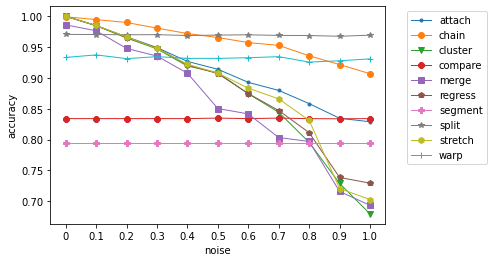

In [10]:
import matplotlib.pyplot as plt
plt.plot(mean_attach_results, color='tab:blue', linewidth=1, marker='.')
plt.plot(mean_chain_results, color='tab:orange', linewidth=1, marker='o')
plt.plot(mean_cluster_results, color='tab:green', linewidth=1, marker='v')
plt.plot(mean_compare_results, color='tab:red', linewidth=1, marker='8')
plt.plot(mean_merge_results, color='tab:purple', linewidth=1, marker='s')
plt.plot(mean_regress_results, color='tab:brown', linewidth=1, marker='p')
plt.plot(mean_segment_results, color='tab:pink', linewidth=1, marker='P')
plt.plot(mean_split_results, color='tab:gray', linewidth=1, marker='*')
plt.plot(mean_stretch_results, color='tab:olive', linewidth=1, marker='h')
plt.plot(mean_warp_results, color='tab:cyan', linewidth=1, marker='+')

plt.legend(['attach','chain', 'cluster', 'compare', 'merge', 'regress', 'segment', 'split', 'stretch', 'warp'], bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.ylabel('accuracy')
plt.xlabel('noise')

x_ticks_labels = ['0', '0.1', '0.2', '0.3', '0.4', '0.5', '0.6', '0.7', '0.8', '0.9', '1.0']
plt.xticks(range(0, 11), x_ticks_labels)
plt.savefig("noise_comparison.png")
plt.show()

In [11]:
print("mean attach:", statistics.mean(mean_attach_results))
print("mean chain:", statistics.mean(mean_chain_results))
print("mean cluster:", statistics.mean(mean_cluster_results))
print("mean compare:", statistics.mean(mean_compare_results))
print("mean merge:", statistics.mean(mean_merge_results))
print("mean regress:", statistics.mean(mean_regress_results))
print("mean segment:", statistics.mean(mean_segment_results))
print("mean split:", statistics.mean(mean_split_results))
print("mean stretch:", statistics.mean(mean_stretch_results))
print("mean warp:", statistics.mean(mean_warp_results))

mean attach: 0.9123507498758238
mean chain: 0.9614845924859465
mean cluster: 0.8769919855404082
mean compare: 0.8341705337978457
mean merge: 0.8595720838925816
mean regress: 0.8843697123892177
mean segment: 0.7940846135267481
mean split: 0.9694237426335482
mean stretch: 0.8848619727539556
mean warp: 0.9319535253694495


In [12]:
#print means of methods from the highest to lowest

means = {}
means['attach'] = statistics.mean(mean_attach_results)
means['chain'] = statistics.mean(mean_chain_results)
means['cluster'] = statistics.mean(mean_cluster_results)
means['compare'] = statistics.mean(mean_compare_results)
means['merge'] = statistics.mean(mean_merge_results)
means['regress'] = statistics.mean(mean_regress_results)
means['segment'] = statistics.mean(mean_segment_results)
means['split'] = statistics.mean(mean_split_results)
means['stretch'] = statistics.mean(mean_stretch_results)
means['warp'] = statistics.mean(mean_warp_results)

sorted_means = dict(sorted(means.items(), key=lambda x:x[1], reverse=True))

for i in sorted_means:
    print(i, sorted_means[i])

split 0.9694237426335482
chain 0.9614845924859465
warp 0.9319535253694495
attach 0.9123507498758238
stretch 0.8848619727539556
regress 0.8843697123892177
cluster 0.8769919855404082
merge 0.8595720838925816
compare 0.8341705337978457
segment 0.7940846135267481
